# 記事

## 作るべきテーブルイメージ


補助金受領回数2020年度宮城県企業テーブルのイメージ：

| 企業ID | 企業名  | 所在地 | 補助金受領回数 |
|--------|--------|--------|----------------|
| 3      | 企業C  | 宮城県 | 3              |
| 1      | 企業A  | 宮城県 | 2              |
| 2      | 企業B  | 宮城県 | 1              |
| 4      | 企業D  | 宮城県 | 1              |


## 関係するAPIをトライ

In [38]:
# APIの基本設定
API_TOKEN = "YOUR_API_TOKEN"  # 実際のAPIトークンに置き換えてください
API_TOKEN = "Hgt7Gj3Il3rQovE8OiU817jgmrKe9jnM"  # テスト後に削除
BASE_URL = "https://info.gbiz.go.jp/hojin/v1/hojin"
HEADERS={
    'accept': 'application/json',
    'X-hojinInfo-api-token': API_TOKEN
}

In [20]:
import requests
from pprint import pprint

response = requests.get(
    BASE_URL, headers=HEADERS,
    params={
        'prefecture': '04',
        'year': '2020',
        'source': '5',
        'page': '1',
        'limit': '1'
    }
)

pprint(response.json())

{'errors': None,
 'hojin-infos': [{'corporate_number': '1000020042129',
                  'location': '宮城県登米市迫町佐沼字中江２丁目６－１',
                  'name': '登米市',
                  'name_en': 'Tome City',
                  'number_of_activity': '207',
                  'postal_code': '9870511',
                  'status': '-',
                  'update_date': '2018-04-02T00:00:00+09:00'}],
 'id': None,
 'message': '200 - OK.'}


In [25]:
response = requests.get(
  f'{BASE_URL}/1000020042129/subsidy', headers=HEADERS,
)
pprint(response.json())

{'errors': None,
 'hojin-infos': [{'corporate_number': '1000020042129',
                  'kana': 'とめし',
                  'location': '宮城県登米市迫町佐沼字中江２丁目６－１',
                  'name': '登米市',
                  'name_en': 'Tome City',
                  'postal_code': '9870511',
                  'status': '-',
                  'subsidy': [{'amount': None,
                               'date_of_approval': None,
                               'government_departments': '経済産業省',
                               'joint_signatures': None,
                               'note': None,
                               'subsidy_resource': None,
                               'target': None,
                               'title': '令和２年度エネルギー構造高度化・転換理解促進事業費補助金（登米市\u3000'
                                        '地域資源を活用した再生可能エネルギー設備導入事業）'},
                              {'amount': '25704000',
                               'date_of_approval': '2024-08-27',
                               'government_de

## DB 設計

In [34]:
from sqlalchemy import create_engine, Column, String, Integer, Date, ForeignKey
from sqlalchemy.orm import relationship
from sqlalchemy.ext.declarative import declarative_base


# データベースエンジンの作成（SQLiteを使用）
DATABASE_URL = 'sqlite:///gbizinfo_miyagi_2020.sqlite3'
engine = create_engine(DATABASE_URL, echo=True)

# Baseクラスの作成
Base = declarative_base()

# 2020年度宮城県企業マスターテーブルの定義
class MiyagiCompanies2020(Base):
    __tablename__ = 'companies'
    
    corporate_number = Column(String, primary_key=True)  # 法人番号（13桁）
    name = Column(String)  # 法人名
    location = Column(String)  # 本社所在地

class MiyagiSubsidies2020(Base):
    __tablename__ = 'subsidies'

    id = Column(Integer, primary_key=True, autoincrement=True)
    corporate_number = Column(String, ForeignKey('companies.corporate_number'))  # 企業の法人番号
    subsidy_title = Column(String)  # 補助金タイトル
    amount = Column(Integer)  # 補助金額
    date_of_approval = Column(Date)  # 補助金承認日
    government_department = Column(String)  # 補助金の政府機関
    target = Column(String)  # 補助金の対象

    # 関連を定義（企業情報と補助金情報を関連付ける）
    company = relationship('MiyagiCompanies2020', backref='subsidies')




# 2020年度宮城県企業マスターテーブルの作成
Base.metadata.create_all(engine)


2025-04-02 14:11:07,381 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-04-02 14:11:07,382 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("companies")


2025-04-02 14:11:07,383 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-04-02 14:11:07,387 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("subsidies")
2025-04-02 14:11:07,387 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-04-02 14:11:07,388 INFO sqlalchemy.engine.Engine COMMIT


/var/folders/pv/3g2620ld3rs7s8h3vfphb4w80000gn/T/ipykernel_2236/126610107.py:11: MovedIn20Warning: The ``declarative_base()`` function is now available as sqlalchemy.orm.declarative_base(). (deprecated since: 2.0) (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  Base = declarative_base()


## データ取得

In [26]:
import requests
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker

# データベース設定
Session = sessionmaker(bind=engine)
session = Session()
Base = declarative_base()


# データ取得＆DB保存
for page in range(1, 11):  # page=1 から page=10 まで
    response = requests.get(
        BASE_URL, headers=HEADERS,
        params={
            'prefecture': '04',  # 宮城県
            'year': '2020',
            'source': '5',
            'page': page,
            'limit': 5000
        }
    )
    
    if response.status_code != 200:
        print(f"エラー: {response.status_code}")
        continue
    
    data = response.json()
    
    for company in data.get('hojin-infos', []):
        new_company = MiyagiCompanies2020(
            corporate_number=company.get('corporate_number'),
            name=company.get('name'),
            location=company.get('location')
        )
        session.add(new_company)

    session.commit()  # 取得したデータをコミット
    print(f"Page {page} のデータを保存しました")

print("データ取得完了！")

/var/folders/pv/3g2620ld3rs7s8h3vfphb4w80000gn/T/ipykernel_2236/2738009454.py:8: MovedIn20Warning: The ``declarative_base()`` function is now available as sqlalchemy.orm.declarative_base(). (deprecated since: 2.0) (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  Base = declarative_base()


2025-04-02 14:01:58,294 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-04-02 14:01:58,298 INFO sqlalchemy.engine.Engine INSERT INTO companies (corporate_number, name, location) VALUES (?, ?, ?)
2025-04-02 14:01:58,298 INFO sqlalchemy.engine.Engine [generated in 0.00104s] [('1000020042129', '登米市', '宮城県登米市迫町佐沼字中江２丁目６－１'), ('1000020042137', '栗原市', '宮城県栗原市築館薬師１丁目７番１号'), ('1000020042153', '大崎市', '宮城県大崎市古川七日町１－１'), ('1000020044067', '利府町', '宮城県宮城郡利府町利府字新並松４'), ('1010001173009', '株式会社ジーデップ・アドバンス', '宮城県仙台市青葉区国分町３丁目４番３３'), ('1030001061582', '株式会社ＭＳＣ', '宮城県仙台市太白区鹿野１丁目４番９'), ('1370001000886', '株式会社アイリスプラザ', '宮城県仙台市青葉区中央２丁目１番７号'), ('1370001001067', 'パイオニアシステムテクノロジー株式会社', '宮城県仙台市青葉区堤町１丁目１番２号')  ... displaying 10 of 356 total bound parameter sets ...  ('9370802000012', '有限会社さくら', '宮城県亘理郡亘理町長瀞字大橋２６１番地４'), ('9400001004769', '株式会社ジェイウッド', '宮城県仙台市泉区大沢３丁目４番１')]
2025-04-02 14:01:58,303 INFO sqlalchemy.engine.Engine COMMIT
Page 1 のデータを保存しました
エラー: 404
エラー: 404
エラー: 404
エラー: 404
エラー: 404
エラー: 404
エラー: 4

In [61]:
# 2020に補助金を受けた宮城県の企業
print(len(response.json().get("hojin-infos", [])))


1


In [40]:
import requests
from datetime import datetime
from sqlalchemy.orm import sessionmaker
from sqlalchemy import create_engine

# データベース接続
DATABASE_URL = 'sqlite:///gbizinfo_miyagi_2020.sqlite3'
engine = create_engine(DATABASE_URL)
Session = sessionmaker(bind=engine)
session = Session()


# 企業リストを取得
companies = session.query(MiyagiCompanies2020).all()

for company in companies:
    corporate_number = company.corporate_number
    response = requests.get(f"{BASE_URL}/{corporate_number}/subsidy", headers=HEADERS)
    
    if response.status_code == 200:
        data = response.json()
        hojin_infos = data.get("hojin-infos", [])
        
        if hojin_infos:
            subsidies = hojin_infos[0].get("subsidy", [])
            
            for sub in subsidies:
                date_of_approval = sub.get("date_of_approval")
                
                if date_of_approval:
                    date_of_approval = datetime.strptime(date_of_approval, '%Y-%m-%d').date()
                    
                    subsidy_record = MiyagiSubsidies2020(
                        corporate_number=corporate_number,
                        subsidy_title=sub.get("title"),
                        amount=int(sub.get("amount") or 0),
                        date_of_approval=date_of_approval,
                        government_department=sub.get("government_departments"),
                        target=sub.get("target")
                    )
                    session.add(subsidy_record)
    else:
        print(f"Error fetching data for {corporate_number}: {response.status_code}")

session.commit()
session.close()
print("補助金データの取得＆保存完了！")


補助金データの取得＆保存完了！


In [41]:
from datetime import datetime

# 企業リストを取得
companies = session.query(MiyagiCompanies2020).all()

for company in companies:
    corporate_number = company.corporate_number
    response = requests.get(f"{BASE_URL}/{corporate_number}/subsidy", headers=HEADERS)
    
    if response.status_code == 200:
        data = response.json()
        hojin_infos = data.get("hojin-infos", [])
        
        if hojin_infos:
            subsidies = hojin_infos[0].get("subsidy", [])
            
            for sub in subsidies:
                date_of_approval = sub.get("date_of_approval")
                
                if date_of_approval:
                    # date_of_approvalが文字列の場合、それをdatetime.dateに変換
                    date_of_approval = datetime.strptime(date_of_approval, '%Y-%m-%d').date()
                    
                    subsidy_record = MiyagiSubsidies2020(
                        corporate_number=corporate_number,
                        subsidy_title=sub.get("title"),
                        amount=int(sub.get("amount") or 0),
                        date_of_approval=date_of_approval,  # ここにdatetime.date型をセット
                        government_department=sub.get("government_departments"),
                        target=sub.get("target")
                    )
                    session.add(subsidy_record)

        # データをコミット（データを保存する）
        session.commit()
    else:
        # エラーハンドリング
        print(f"Error fetching data for corporate_number {corporate_number}: {response.status_code}")


## データ操作

In [ ]:
import pandas as pd

# MiyagiSubsidies2020のレコードを取得
subsidy_records = session.query(MiyagiSubsidies2020).all()

# レコードをリスト形式に変換
subsidy_list = [{
    'corporate_number': record.corporate_number,
    'subsidy_title': record.subsidy_title,
    'amount': record.amount,
    'date_of_approval': record.date_of_approval,
    'government_department': record.government_department,
    'target': record.target
} for record in subsidy_records]

# DataFrameに変換
df_subsidies = pd.DataFrame(subsidy_list)

df_subsidies.head()

,corporate_number,subsidy_title,amount,date_of_approval,government_department,target
0,1000020042129,循環型社会形成推進交付金,25704000,2024-08-27,環境省,None
1,1000020042129,消防防災施設整備事業,7992000,2024-05-31,総務省,None
2,1000020042129,緊急消防援助隊設備整備費補助事業,10145000,2024-05-31,総務省,None
3,1000020042129,廃棄物処理施設モニタリング等事業費補助金,198000,2024-04-08,環境省,None
4,1000020042129,循環型社会形成推進交付金,25870000,2023-08-28,環境省,None


In [64]:
df_subsidies.info

<bound method DataFrame.info of       corporate_number         subsidy_title    amount date_of_approval  \
0        1000020042129          循環型社会形成推進交付金  25704000       2024-08-27   
1        1000020042129            消防防災施設整備事業   7992000       2024-05-31   
2        1000020042129      緊急消防援助隊設備整備費補助事業  10145000       2024-05-31   
3        1000020042129  廃棄物処理施設モニタリング等事業費補助金    198000       2024-04-08   
4        1000020042129          循環型社会形成推進交付金  25870000       2023-08-28   
...                ...                   ...       ...              ...   
11271    9370202005116              経営所得安定対策   2890492       2015-12-22   
11272    9370202005116              経営所得安定対策  14757449       2015-12-15   
11273    9370202005116              経営所得安定対策   2413500       2015-12-08   
11274    9370202005116              経営所得安定対策   1752000       2015-09-15   
11275    9370202005116              経営所得安定対策    305256       2015-06-23   

      government_department target  
0                       環境省   

In [71]:
df_subsidies_count = df_subsidies.groupby('corporate_number').agg(
    subsidy_count=('corporate_number', 'size'),  # 回数をカウント
    total_amount=('amount', 'sum')  # 合計金額を集計
).reset_index()



In [72]:
df_subsidies_count

,corporate_number,subsidy_count,total_amount
0,1000020042129,364,59622191470
1,1000020042137,382,49250998572
2,1000020042153,370,83777143796
3,1000020044067,204,12347289206
4,1370001001208,2,314000
...,...,...,...
107,9370001042046,2,2000000
108,9370005001428,58,445812000
109,9370005004075,68,559478008
110,9370202003581,4,2400000


In [79]:
company_records = session.query(MiyagiCompanies2020).all()

In [80]:
# 企業データをリスト形式に変換
companies_list = [{"corporate_number": company.corporate_number, "name": company.name} for company in company_records]

# pandas DataFrameに変換
df_companies = pd.DataFrame(companies_list)

# 企業テーブル（df_companies）を外部結合
df_merged = pd.merge(df_subsidies_count, df_companies[['corporate_number', 'name']], on='corporate_number', how='left')

# 受給回数で降順にソート
df_merged_sorted = df_merged.sort_values(by='subsidy_count', ascending=False)

# 結果の確認
print(df_merged_sorted.head())


   corporate_number  subsidy_count   total_amount        name
91    8000020040002           4146  2242584650922         宮城県
92    8000020041009           1044   796801501176         仙台市
88    7370005002147            592    55486962820  国立大学法人東北大学
93    8000020042056            516   124306960974        気仙沼市
43    4000020046060            382    40902517220        南三陸町


In [82]:
df_merged_sorted.head()

,corporate_number,subsidy_count,total_amount,name
91,8000020040002,4146,2242584650922,宮城県
92,8000020041009,1044,796801501176,仙台市
88,7370005002147,592,55486962820,国立大学法人東北大学
93,8000020042056,516,124306960974,気仙沼市
43,4000020046060,382,40902517220,南三陸町


In [83]:
df_merged_sorted.info

<bound method DataFrame.info of    corporate_number  subsidy_count   total_amount                 name
91    8000020040002           4146  2242584650922                  宮城県
92    8000020041009           1044   796801501176                  仙台市
88    7370005002147            592    55486962820           国立大学法人東北大学
93    8000020042056            516   124306960974                 気仙沼市
43    4000020046060            382    40902517220                 南三陸町
..              ...            ...            ...                  ...
82    7370001002786              2         880000             小山産業株式会社
83    7370001024401              2         282000  株式会社　ａ　ｐａｒｔ　ｏｆ　ｌｉｆｅ
84    7370001039556              2              0           株式会社ｖｅｅｅｌｌ
23    2370001044569              2              0           株式会社ＵＳリサーチ
69    6370001021928              2        1000000         株式会社雲の上カンパニー

[112 rows x 4 columns]>

TypeError: Invalid object type at position 0

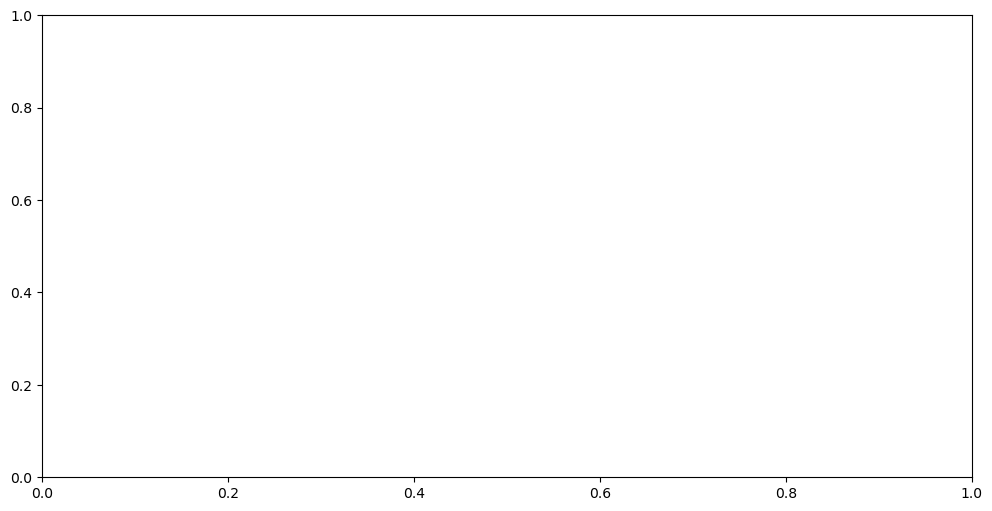

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 上位の企業データ（任意で数を制限）


# グラフの設定
plt.figure(figsize=(12, 6))

# 散布図としてプロット
sns.lineplot(x='name', y='subsidy_count', data= df_merged_sorted, marker='o', color='b')

# グラフのタイトルやラベルを設定
plt.title(f'Subsidy Count (Line Plot)', fontsize=16)
plt.xlabel('Company Name', fontsize=12)
plt.ylabel('Subsidy Count', fontsize=12)

# x軸のラベルを回転させる
plt.xticks(rotation=45, ha='right')

# グラフの表示
plt.tight_layout()
plt.show()


/var/folders/pv/3g2620ld3rs7s8h3vfphb4w80000gn/T/ipykernel_2236/636037746.py:22: UserWarning: Glyph 23470 (\N{CJK UNIFIED IDEOGRAPH-5BAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/pv/3g2620ld3rs7s8h3vfphb4w80000gn/T/ipykernel_2236/636037746.py:22: UserWarning: Glyph 22478 (\N{CJK UNIFIED IDEOGRAPH-57CE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/pv/3g2620ld3rs7s8h3vfphb4w80000gn/T/ipykernel_2236/636037746.py:22: UserWarning: Glyph 30476 (\N{CJK UNIFIED IDEOGRAPH-770C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/pv/3g2620ld3rs7s8h3vfphb4w80000gn/T/ipykernel_2236/636037746.py:22: UserWarning: Glyph 12473 (\N{KATAKANA LETTER SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/pv/3g2620ld3rs7s8h3vfphb4w80000gn/T/ipykernel_2236/636037746.py:22: UserWarning: Glyph 12514 (\N{KATAKANA LETTER MO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/pv/3g2620ld3rs7s8h3vfphb4w80000gn

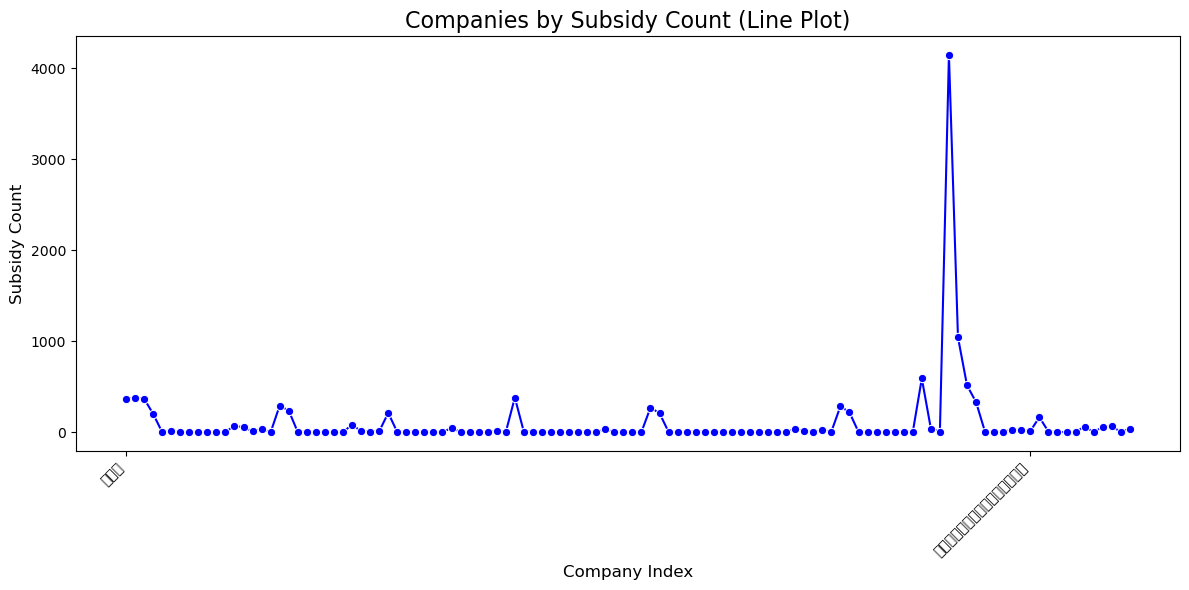

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns

# 受給回数で降順に並べる
df_merged_sorted = df_merged.sort_values(by='subsidy_count', ascending=False)

# グラフの設定
plt.figure(figsize=(12, 6))

# 受給回数をy軸、企業名をx軸にして線グラフをプロット
sns.lineplot(x=df_merged_sorted.index, y='subsidy_count', data=df_merged_sorted, marker='o', color='b')

# グラフのタイトルやラベルを設定
plt.title('Companies by Subsidy Count (Line Plot)', fontsize=16)
plt.xlabel('Company Index', fontsize=12)
plt.ylabel('Subsidy Count', fontsize=12)

# x軸のラベルを100件おきに設定
plt.xticks(ticks=range(0, len(df_merged_sorted), 100), labels=df_merged_sorted['name'][::100], rotation=45, ha='right')

# グラフの表示
plt.tight_layout()
plt.show()
